## Importing Modules

In [2]:
#%matplotlib notebook
from tqdm import tqdm
%matplotlib inline
#Module to handle regular expressions
import re
#manage files
import os
#Library for emoji
import emoji
#Import pandas and numpy to handle data
import pandas as pd
import numpy as np

#import libraries for accessing the database
import psycopg2
from sqlalchemy import create_engine
from postgres_credentials import *

#import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

#Import nltk to check english lexicon
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import (
    wordnet,
    stopwords
)

#import libraries for tokenization and ML
import json;
import keras;
import keras.preprocessing.text as kpt;
#from keras.preprocessing.text import Tokenizer;

import sklearn
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Import all libraries for creating a deep neural network
#Sequential is the standard type of neural network with stackable layers
from keras.models import (
    Sequential,
    model_from_json
)
#Dense: Standard layers with every node connected, dropout: avoids overfitting
from keras.layers import Dense, Dropout, Activation;

#To anotate database
from pycorenlp import StanfordCoreNLP

Using TensorFlow backend.


In [3]:
#Querying the database
def query_database(tabletweets):
    engine = create_engine("postgresql+psycopg2://%s:%s@%s:%d/%s" %(usertwitter, passwordtwitter, hosttwitter, porttwitter, dbnametwitter))
    table = pd.read_sql_query("select * from %s" %tabletweets,con=engine, index_col="id")
    return table

## Preprocessing the text

Before we dig into analyzing the public opinion on 'Avengers', there is an important step that we need to take: preprocessing the tweet text. But what does this mean? Text preprocessing includes a basic text cleaning following a set of simple rules commonly used but also, advanced techniques that takes into account syntactic and lexical information.

In [4]:
#preprocess text in tweets by removing links, @UserNames, blank spaces, etc.
def preprocessing_text(table):
    #put everythin in lowercase
    table['tweet'] = table['tweet'].str.lower()
    #Replace rt indicating that was a retweet
    table['tweet'] = table['tweet'].str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    table['tweet'] = table['tweet'].replace(r'@\w+', '', regex=True)
    #Replace links contained in the tweet
    table['tweet'] = table['tweet'].replace(r'http\S+', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'www.[^ ]+', '', regex=True)
    #remove numbers
    table['tweet'] = table['tweet'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    table['tweet'] = table['tweet'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    return table    

In [5]:
#Replace elongated words by identifying those repeated characters and then remove them and compare the new word with the english lexicon
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row 

In [6]:
def stop_words(table):
    #We need to remove the stop words
    stop_words_list = stopwords.words('english')
    table['tweet'] = table['tweet'].str.lower()
    table['tweet'] = table['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table

In [7]:
def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word
            
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speach_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    #Now we ask if we found a negation in the words
    tags_2 = ''
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1] 
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speach_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)    

In [8]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    table = preprocessing_text(table)
    table['tweet'] = table['tweet'].apply(lambda x: detect_elongated_words(x))
    table['tweet'] = table['tweet'].apply(lambda x: handling_negation(x))
    table = stop_words(table)
    return table

## Data Visualization

After we have cleaned our data but before we start building our model for sentiment analysis, we can perform an exploratory data analysis to see what are the most frequent words that appear in our 'Avengers' tweets. For this part, we will show graphs regarding tweets labelled as positive separated from those labelled as negative.

In [9]:
#Vectorization for Data Visualization
def vectorization(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table.tweet)
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [10]:
def word_cloud(tweets):
    
    #We get the directory that we are working on
    file = os.getcwd()
    #We read the mask image into a numpy array
    avengers_mask = np.array(Image.open(os.path.join(file, "avengers.png")))
    #Now we store the tweets into a series to be able to process 
    #tweets_list = pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' ')  
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, background_color="black", max_words=2000, mask=avengers_mask, contour_width=1, 
                           contour_color="steelblue", colormap="nipy_spectral", stopwords=["avengers"])
    word_cloud.generate(tweets)
    
    #wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_list)
    
    #Now we plot both figures, the wordcloud and the mask
    #plt.figure(figsize=(15,15))
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")
    #plt.imshow(avengers_mask, cmap=plt.cm.gray, interpolation="bilinear")
    #plt.axis("off")    
    plt.show()  

In [11]:
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show() 

In [12]:
def regression_graph(table):
    table = table[1:]
    #We set the style of seaborn
    sns.set_style("whitegrid")   
    #Initialize the figure
    plt.figure(figsize=(6,6))
    
    #we obtain the points from matplotlib scatter
    points = plt.scatter(table["Positive"], table["Negative"], c=table["Positive"], s=75, cmap="bwr")
    #graph the colorbar
    plt.colorbar(points)
    #we graph the regplot from seaborn
    sns.regplot(x="Positive", y="Negative",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word frequency in Positive vs. Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

## Preparing data for model

After visualizing our data, the next step is to split our dataset into training and test sets. For doing so, we'll take advantage of the train_test_split functionality of sklearn package. We will take 20% of the dataset for testing following the 20–80% rule. From the remaining 80% used for the training set, we'll save a part for validation of our model.

In [13]:
#Split Data into training and test dataset
def splitting(table):
    X_train, X_test, y_train, y_test = train_test_split(table.tweet, table.sentiment, test_size=0.2, shuffle=True)
    return X_train, X_test, y_train, y_test

m

In [14]:
#Tokenization for analysis
def tokenization_tweets(dataset, features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

## Train model

In [15]:
#Create a Neural Network
#Create the model
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=validation,
                 shuffle=shuffle)
    return model_nn

## Test model

In [16]:
def test(X_test, model_nn):
    prediction = model_nn.predict(X_test)
    return prediction

## Main code

In [17]:
if __name__ == "__main__":
    tabletweets = "tweets_avengers"
    tweet_table = query_database(tabletweets)
    tweet_table = cleaning_table(tweet_table)

In [ ]:
if __name__ == "__main__":    
    #First we draw a word cloud
    #For All tweets
    word_cloud(pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' '))    
    #For positive tweets 
    word_cloud(pd.Series([t for t in tweet_table[tweet_table.sentiment == "Positive"].tweet]).str.cat(sep=' '))   
    #For negative tweets
    word_cloud(pd.Series([t for t in tweet_table[tweet_table.sentiment == "Negative"].tweet]).str.cat(sep=' '))

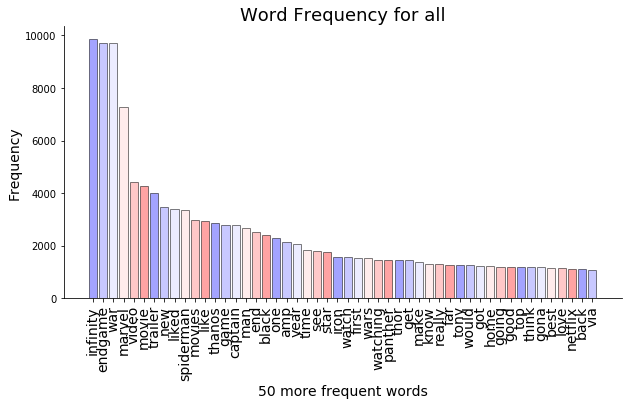

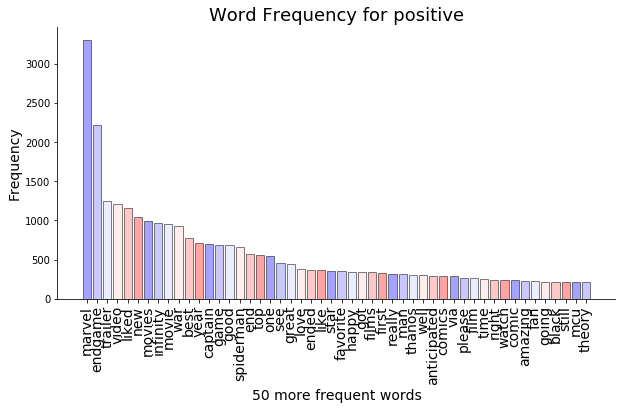

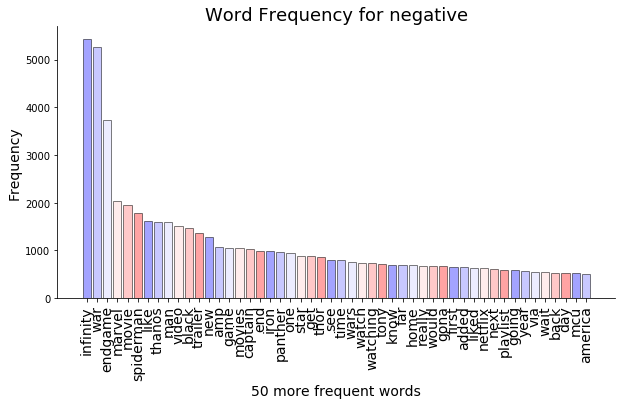

In [21]:
if __name__ == "__main__":
    #Get the frequency
    word_frequency = vectorization(tweet_table).sort_values(0, ascending = False)
    word_frequency_pos = vectorization(tweet_table[tweet_table['sentiment'] == 'Positive']).sort_values(0, ascending = False)
    word_frequency_neg = vectorization(tweet_table[tweet_table['sentiment'] == 'Negative']).sort_values(0, ascending = False)

    #Graph with frequency words all, positive and negative tweets and get the frequency
    graph(word_frequency, 'all')
    graph(word_frequency_pos, 'positive')
    graph(word_frequency_neg, 'negative')

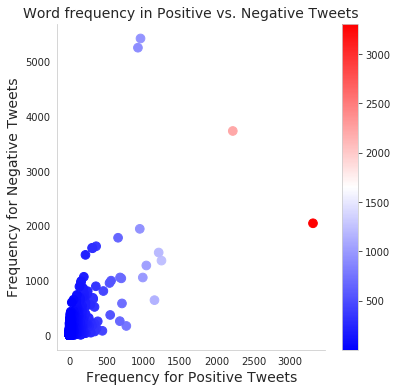

In [22]:
if __name__ == "__main__":
    #Concatenate word frequency for positive and negative
    table_regression = pd.concat([word_frequency_pos, word_frequency_neg], axis=1, sort=False)
    table_regression.columns = ["Positive", "Negative"]
    regression_graph(table_regression)

In [18]:
if __name__ == "__main__":
    tabletweets = "tweets_avengers_labeled"
    tweet_table = query_database(tabletweets)

In [19]:
if __name__ == "__main__":
    tweet_table['sentiment'] = tweet_table['sentiment'].apply(lambda x: 2 if x == 'Positive' else (0 if x == 'Negative' else 1))

In [20]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = splitting(tweet_table)

In [32]:
def model1(X_train, y_train):   
    features = 3500
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.001
    epsilon = None
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model1(X_train, y_train)

Train on 50712 samples, validate on 5635 samples
Epoch 1/5
50712/50712 [==============================] - 31s 618us/step - loss: 0.7807 - acc: 0.6350 - val_loss: 0.6618 - val_acc: 0.7043
Epoch 2/5
50712/50712 [==============================] - 31s 621us/step - loss: 0.5936 - acc: 0.7435 - val_loss: 0.6160 - val_acc: 0.7366
Epoch 3/5
50712/50712 [==============================] - 31s 602us/step - loss: 0.5211 - acc: 0.7807 - val_loss: 0.6024 - val_acc: 0.7462
Epoch 4/5
50712/50712 [==============================] - 32s 624us/step - loss: 0.4506 - acc: 0.8161 - val_loss: 0.6097 - val_acc: 0.7531
Epoch 5/5
50712/50712 [==============================] - 30s 597us/step - loss: 0.3870 - acc: 0.8419 - val_loss: 0.6486 - val_acc: 0.7542


In [33]:
def model2(X_train, y_train):   
    features = 3000
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.001
    epsilon = None
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model2(X_train, y_train)

Train on 50712 samples, validate on 5635 samples
Epoch 1/5
50712/50712 [==============================] - 26s 513us/step - loss: 0.7911 - acc: 0.6289 - val_loss: 0.6542 - val_acc: 0.7150
Epoch 2/5
50712/50712 [==============================] - 26s 512us/step - loss: 0.6067 - acc: 0.7405 - val_loss: 0.6259 - val_acc: 0.7315
Epoch 3/5
50712/50712 [==============================] - 27s 528us/step - loss: 0.5324 - acc: 0.7780 - val_loss: 0.6173 - val_acc: 0.7429
Epoch 4/5
50712/50712 [==============================] - 27s 528us/step - loss: 0.4668 - acc: 0.8118 - val_loss: 0.6237 - val_acc: 0.7496
Epoch 5/5
50712/50712 [==============================] - 26s 507us/step - loss: 0.4003 - acc: 0.8408 - val_loss: 0.6544 - val_acc: 0.7478


In [10]:
def model3(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = None
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model_final = model3(X_train, y_train)

Train on 50712 samples, validate on 5635 samples
Epoch 1/5
50712/50712 [==============================] - 32s 631us/step - loss: 0.7493 - acc: 0.6528 - val_loss: 0.6321 - val_acc: 0.7244
Epoch 2/5
50712/50712 [==============================] - 32s 626us/step - loss: 0.5775 - acc: 0.7510 - val_loss: 0.5998 - val_acc: 0.7400
Epoch 3/5
50712/50712 [==============================] - 30s 587us/step - loss: 0.4820 - acc: 0.7993 - val_loss: 0.5909 - val_acc: 0.7571
Epoch 4/5
50712/50712 [==============================] - 29s 568us/step - loss: 0.3842 - acc: 0.8428 - val_loss: 0.6090 - val_acc: 0.7588
Epoch 5/5
50712/50712 [==============================] - 28s 561us/step - loss: 0.3088 - acc: 0.8778 - val_loss: 0.6868 - val_acc: 0.7567


In [35]:
def model4(X_train, y_train):   
    features = 5000
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 2
    lr = 0.005
    epsilon = None
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model4(X_train, y_train)

Train on 50712 samples, validate on 5635 samples
Epoch 1/2
50712/50712 [==============================] - 48s 940us/step - loss: 0.7415 - acc: 0.6609 - val_loss: 0.6593 - val_acc: 0.6978
Epoch 2/2
50712/50712 [==============================] - 46s 916us/step - loss: 0.5386 - acc: 0.7729 - val_loss: 0.6040 - val_acc: 0.7464


In [36]:
def model5(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-5
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model5(X_train, y_train)

Train on 50712 samples, validate on 5635 samples
Epoch 1/5
50712/50712 [==============================] - 35s 682us/step - loss: 0.7565 - acc: 0.6494 - val_loss: 0.6422 - val_acc: 0.7177
Epoch 2/5
50712/50712 [==============================] - 33s 641us/step - loss: 0.5799 - acc: 0.7501 - val_loss: 0.6225 - val_acc: 0.7390
Epoch 3/5
50712/50712 [==============================] - 31s 617us/step - loss: 0.4789 - acc: 0.7993 - val_loss: 0.6002 - val_acc: 0.7528
Epoch 4/5
50712/50712 [==============================] - 30s 585us/step - loss: 0.3826 - acc: 0.8435 - val_loss: 0.6432 - val_acc: 0.7555
Epoch 5/5
50712/50712 [==============================] - 29s 579us/step - loss: 0.3044 - acc: 0.8781 - val_loss: 0.7099 - val_acc: 0.7567


In [37]:
def model6(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model6(X_train, y_train)

Train on 50712 samples, validate on 5635 samples
Epoch 1/5
50712/50712 [==============================] - 31s 611us/step - loss: 0.7512 - acc: 0.6506 - val_loss: 0.6474 - val_acc: 0.7154
Epoch 2/5
50712/50712 [==============================] - 30s 588us/step - loss: 0.5740 - acc: 0.7541 - val_loss: 0.6135 - val_acc: 0.7429
Epoch 3/5
50712/50712 [==============================] - 30s 584us/step - loss: 0.4728 - acc: 0.8011 - val_loss: 0.6122 - val_acc: 0.7555
Epoch 4/5
50712/50712 [==============================] - 30s 583us/step - loss: 0.3772 - acc: 0.8446 - val_loss: 0.6569 - val_acc: 0.7601
Epoch 5/5
50712/50712 [==============================] - 29s 575us/step - loss: 0.2982 - acc: 0.8799 - val_loss: 0.7419 - val_acc: 0.7622


In [21]:
def model7(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 6
    lr = 0.002
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
#model7(X_train, y_train)

In [39]:
def model8(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-9
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model8(X_train, y_train)

Train on 50712 samples, validate on 5635 samples
Epoch 1/5
50712/50712 [==============================] - 31s 604us/step - loss: 0.7501 - acc: 0.6550 - val_loss: 0.6384 - val_acc: 0.7169
Epoch 2/5
50712/50712 [==============================] - 30s 585us/step - loss: 0.5578 - acc: 0.7635 - val_loss: 0.6035 - val_acc: 0.7446
Epoch 3/5
50712/50712 [==============================] - 31s 612us/step - loss: 0.4481 - acc: 0.8158 - val_loss: 0.6171 - val_acc: 0.7535
Epoch 4/5
50712/50712 [==============================] - 30s 596us/step - loss: 0.3473 - acc: 0.8606 - val_loss: 0.6674 - val_acc: 0.7544
Epoch 5/5
50712/50712 [==============================] - 29s 579us/step - loss: 0.2718 - acc: 0.8933 - val_loss: 0.7278 - val_acc: 0.7583


In [40]:
def model9(X_train, y_train):   
    features = 3500
    shufle = False
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-9
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model9(X_train, y_train)

Train on 50712 samples, validate on 5635 samples
Epoch 1/5
50712/50712 [==============================] - 32s 627us/step - loss: 0.7528 - acc: 0.6510 - val_loss: 0.6414 - val_acc: 0.7235
Epoch 2/5
50712/50712 [==============================] - 31s 604us/step - loss: 0.5797 - acc: 0.7487 - val_loss: 0.6163 - val_acc: 0.7363
Epoch 3/5
50712/50712 [==============================] - 30s 594us/step - loss: 0.4815 - acc: 0.7966 - val_loss: 0.6467 - val_acc: 0.7448
Epoch 4/5
50712/50712 [==============================] - 30s 584us/step - loss: 0.3849 - acc: 0.8397 - val_loss: 0.7066 - val_acc: 0.7491
Epoch 5/5
50712/50712 [==============================] - 29s 572us/step - loss: 0.3099 - acc: 0.8756 - val_loss: 0.7812 - val_acc: 0.7516


In [42]:
def model10(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-9
    validation = 0.2
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model10(X_train, y_train)

Train on 45077 samples, validate on 11270 samples
Epoch 1/5
45077/45077 [==============================] - 29s 638us/step - loss: 0.7670 - acc: 0.6466 - val_loss: 0.6403 - val_acc: 0.7220
Epoch 2/5
45077/45077 [==============================] - 28s 613us/step - loss: 0.5729 - acc: 0.7542 - val_loss: 0.6180 - val_acc: 0.7405
Epoch 3/5
45077/45077 [==============================] - 27s 603us/step - loss: 0.4638 - acc: 0.8089 - val_loss: 0.6058 - val_acc: 0.7507
Epoch 4/5
45077/45077 [==============================] - 27s 594us/step - loss: 0.3630 - acc: 0.8544 - val_loss: 0.6533 - val_acc: 0.7577
Epoch 5/5
45077/45077 [==============================] - 26s 587us/step - loss: 0.2856 - acc: 0.8895 - val_loss: 0.7454 - val_acc: 0.7541


In [43]:
def model11(X_train, y_train):   
    features = 3000
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-9
    validation = 0.2
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model11(X_train, y_train)

Train on 45077 samples, validate on 11270 samples
Epoch 1/5
45077/45077 [==============================] - 24s 536us/step - loss: 0.7652 - acc: 0.6451 - val_loss: 0.6463 - val_acc: 0.7149
Epoch 2/5
45077/45077 [==============================] - 23s 520us/step - loss: 0.5918 - acc: 0.7443 - val_loss: 0.6155 - val_acc: 0.7323
Epoch 3/5
45077/45077 [==============================] - 23s 509us/step - loss: 0.4941 - acc: 0.7930 - val_loss: 0.6149 - val_acc: 0.7403
Epoch 4/5
45077/45077 [==============================] - 23s 505us/step - loss: 0.4027 - acc: 0.8348 - val_loss: 0.6474 - val_acc: 0.7509
Epoch 5/5
45077/45077 [==============================] - 23s 499us/step - loss: 0.3196 - acc: 0.8720 - val_loss: 0.7078 - val_acc: 0.7446


In [22]:
def save_model(model):
    model_json = model.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)

    model.save_weights('model.h5')

model_final = model7(X_train, y_train)
save_model(model_final)

Train on 50712 samples, validate on 5635 samples
Epoch 1/6
50712/50712 [==============================] - 31s 605us/step - loss: 0.7494 - acc: 0.6563 - val_loss: 0.6383 - val_acc: 0.7184
Epoch 2/6
50712/50712 [==============================] - 30s 592us/step - loss: 0.5682 - acc: 0.7579 - val_loss: 0.6104 - val_acc: 0.7372
Epoch 3/6
50712/50712 [==============================] - 30s 585us/step - loss: 0.4699 - acc: 0.8040 - val_loss: 0.6132 - val_acc: 0.7473
Epoch 4/6
50712/50712 [==============================] - 29s 577us/step - loss: 0.3716 - acc: 0.8485 - val_loss: 0.6809 - val_acc: 0.7500
Epoch 5/6
50712/50712 [==============================] - 29s 571us/step - loss: 0.2952 - acc: 0.8828 - val_loss: 0.7199 - val_acc: 0.7595
Epoch 6/6
50712/50712 [==============================] - 29s 571us/step - loss: 0.2402 - acc: 0.9057 - val_loss: 0.8126 - val_acc: 0.7618


In [33]:
if __name__ == "__main__":
    tabletweetsnew = "tweets_predict_avengers"
    tweet_table_new = query_database(tabletweetsnew)
    tweet_table_new = cleaning_table(tweet_table_new)

In [36]:
if __name__ == "__main__":
    X_new = tokenization_tweets(tweet_table_new.tweet, 3500)
    new_prediction = model_final.predict(X_new)

In [88]:
if __name__ == "__main__":
    labels = ['Negative', 'Neutral', 'Positive']
    sentiments = [labels[np.argmax(pred)] for pred in new_prediction]
    tweet_table_new["sentiment"] = sentiments

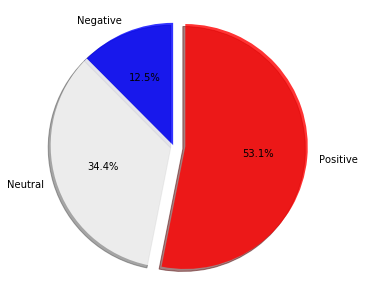

In [103]:
sizes = [sentiments.count('Negative'), sentiments.count('Neutral'), sentiments.count('Positive')]
explode = (0, 0, 0.1)
labels = 'Negative', 'Neutral', 'Positive'
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, colors="bwr", labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops={'alpha':0.8})
plt.axis('equal') 
plt.show()

In [105]:
if __name__ == "__main__":
    engine = create_engine("postgresql+psycopg2://%s:%s@%s:%d/%s" %(usertwitter, passwordtwitter, hosttwitter, porttwitter, dbnametwitter))
    tweet_table_new.to_sql("tweets_avengers_new_labeled", con=engine, if_exists="append") 

### Extra analysis for interaction network

In [24]:
if __name__ == "__main__":
    tweet_table_interaction = pd.read_csv("tweets_final.csv")
    tweet_table_interaction.rename(columns = {"text": "tweet"}, inplace=True)
    tweet_table_interaction = cleaning_table(tweet_table_interaction) 
    X_interaction = tokenization_tweets(tweet_table_interaction.tweet, 3500)

In [27]:
if __name__ == "__main__":
    # Open json file of saved model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    # Create a model 
    model = model_from_json(loaded_model_json)
    # Weight nodes with saved values
    model.load_weights('model.h5')

In [28]:
if __name__ == "__main__":
    int_prediction = model.predict(X_interaction)
    labels = ['Negative', 'Neutral', 'Positive']
    sentiments = [labels[np.argmax(pred)] for pred in int_prediction]
    tweet_table_interaction["sentiment"] = sentiments

In [30]:
tweet_table_interaction.to_csv("tweets_final_sentiment.csv")